In [1]:
import os
from pathlib import Path

import gpytorch
import numpy as np
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import LinearMean
from scipy.stats import qmc
from torchmetrics import MeanSquaredError, R2Score

from GPErks.gp.data.dataset import Dataset
from GPErks.gp.experiment import GPExperiment
from GPErks.log.logger import get_logger
from GPErks.perks.inference import Inference
from GPErks.serialization.path import posix_path
from GPErks.train.early_stop import (
    NoEarlyStoppingCriterion,
    PkEarlyStoppingCriterion,
)
from GPErks.train.emulator import GPEmulator
from GPErks.train.snapshot import EveryEpochSnapshottingCriterion
from GPErks.utils.random import set_seed
from GPErks.utils.test_functions import forrester

In [2]:
log = get_logger()
seed = 8
set_seed(seed)  # reproducible sampling

In [3]:
# function to learn
f = lambda X: np.array([forrester(x) for x in X])

In [4]:
# build dataset
sampler = qmc.LatinHypercube(d=1, seed=seed)
train_sample_size = 15
X_train = sampler.random(n=train_sample_size).ravel()
y_train = f(X_train)

test_sample_size = 100
X_test = np.linspace(0, 1, test_sample_size)
y_test = f(X_test)

dataset = Dataset(X_train, y_train, X_test=X_test, y_test=y_test)

In [5]:
# define experiment options
likelihood = gpytorch.likelihoods.GaussianLikelihood()

input_size = 1
mean_function = LinearMean(input_size=input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=input_size))

metrics = [R2Score(), MeanSquaredError()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=2,
    metrics=metrics,
    seed=seed,  # reproducible training
)

In [6]:
# define training options
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
device = "cuda" if torch.cuda.is_available() else "cpu"

max_epochs = 100
early_stopping_criterion = PkEarlyStoppingCriterion(
    max_epochs, alpha=0.01, patience=8, strip_length=20
)

snapshot_dir = posix_path("./", "snapshot", "notebook")
os.makedirs(snapshot_dir, exist_ok=True)
snapshotting_criterion = EveryEpochSnapshottingCriterion(
    posix_path(snapshot_dir, "restart_{restart}"),
    "epoch_{epoch}.pth",
)

In [7]:
# train model
emul = GPEmulator(experiment, device)
best_model, best_train_stats = emul.train(
    optimizer,
    early_stopping_criterion,
    snapshotting_criterion,
)

INFO:2021-07-29 17:43:51,054:emulator:train:L61: Training emulator...
INFO:2021-07-29 17:43:53,405:emulator:train:L77: Running restart 1...
/home/gianvito/personal/GPErks/venv/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:25: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)
  L = torch.cholesky(A, upper=upper, out=out)
/home/gianvito/personal/GPErks/venv/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,
INFO:2021-07-29 17:43:53,440:emulator:_train_once:L286: [  1/100] Training Loss

INFO:2021-07-29 17:43:54,242:emulator:_train_once:L286: [ 56/100] Training Loss: 1.3791 - R2Score: 0.0962 - MeanSquaredError: 0.9038
INFO:2021-07-29 17:43:54,256:emulator:_train_once:L286: [ 57/100] Training Loss: 1.3786 - R2Score: 0.0965 - MeanSquaredError: 0.9035
INFO:2021-07-29 17:43:54,268:emulator:_train_once:L286: [ 58/100] Training Loss: 1.3779 - R2Score: 0.0965 - MeanSquaredError: 0.9035
INFO:2021-07-29 17:43:54,279:emulator:_train_once:L286: [ 59/100] Training Loss: 1.3773 - R2Score: 0.0963 - MeanSquaredError: 0.9037
INFO:2021-07-29 17:43:54,282:emulator:train:L90: Run restart 1.
INFO:2021-07-29 17:43:54,283:emulator:train:L77: Running restart 2...
INFO:2021-07-29 17:43:54,309:emulator:_train_once:L286: [  1/100] Training Loss: 1.6051 - R2Score: 0.1773 - MeanSquaredError: 0.8227
INFO:2021-07-29 17:43:54,322:emulator:_train_once:L286: [  2/100] Training Loss: 1.5890 - R2Score: 0.1877 - MeanSquaredError: 0.8123
INFO:2021-07-29 17:43:54,336:emulator:_train_once:L286: [  3/100] Tr

INFO:2021-07-29 17:43:55,147:emulator:_train_once:L286: [ 58/100] Training Loss: 0.0681 - R2Score: 0.9999 - MeanSquaredError: 0.0001
INFO:2021-07-29 17:43:55,161:emulator:_train_once:L286: [ 59/100] Training Loss: 0.0532 - R2Score: 0.9999 - MeanSquaredError: 0.0001
INFO:2021-07-29 17:43:55,176:emulator:_train_once:L286: [ 60/100] Training Loss: 0.0395 - R2Score: 1.0000 - MeanSquaredError: 0.0000
INFO:2021-07-29 17:43:55,190:emulator:_train_once:L286: [ 61/100] Training Loss: 0.0262 - R2Score: 1.0000 - MeanSquaredError: 0.0000
INFO:2021-07-29 17:43:55,203:emulator:_train_once:L286: [ 62/100] Training Loss: 0.0137 - R2Score: 1.0000 - MeanSquaredError: 0.0000
INFO:2021-07-29 17:43:55,215:emulator:_train_once:L286: [ 63/100] Training Loss: 0.0021 - R2Score: 1.0000 - MeanSquaredError: 0.0000
INFO:2021-07-29 17:43:55,227:emulator:_train_once:L286: [ 64/100] Training Loss: -0.0091 - R2Score: 1.0000 - MeanSquaredError: 0.0000
INFO:2021-07-29 17:43:55,239:emulator:_train_once:L286: [ 65/100] Tr


Bias: 0.1042
Weights: 0.7037985324859619
Outputscale: 2.5985
Lengthscales: 0.16186577081680298
Likelihood noise: 0.0001


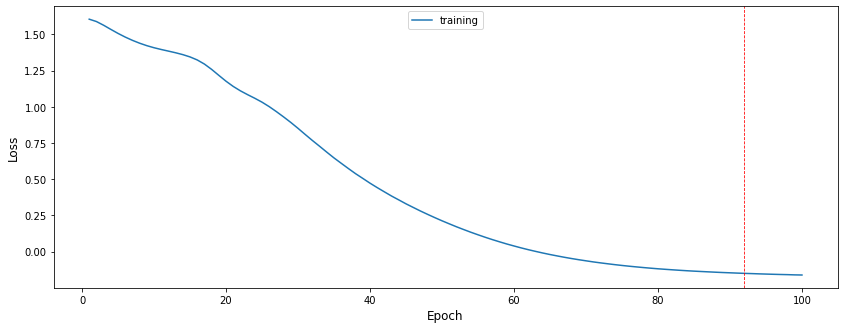

In [8]:
# plot graphs
best_train_stats.plot()

                   Score
R2Score           0.9999
MeanSquaredError  0.0017


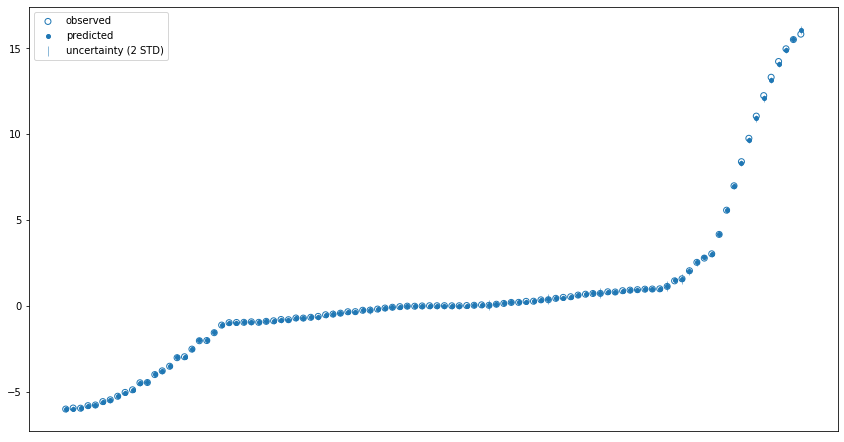

In [9]:
# test model
inference = Inference(emul)
inference.summary()
inference.plot()